# Decision Tree

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import pipeline
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute
from sklearn import model_selection
from matplotlib import pyplot as plt

# Pre-processing

## Reading csv


In [2]:
dataset = pd.read_csv("./dataset.csv")
dataset.drop(["Unnamed: 0", "track_id", "track_name", "album_name"], axis=1, inplace=True)

## Show data

In [3]:
print(dataset.shape)
print()
dataset.info()
dataset.head()

(114000, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113999 non-null  object 
 1   popularity        114000 non-null  int64  
 2   duration_ms       114000 non-null  int64  
 3   explicit          114000 non-null  bool   
 4   danceability      114000 non-null  float64
 5   energy            114000 non-null  float64
 6   key               114000 non-null  int64  
 7   loudness          114000 non-null  float64
 8   mode              114000 non-null  int64  
 9   speechiness       114000 non-null  float64
 10  acousticness      114000 non-null  float64
 11  instrumentalness  114000 non-null  float64
 12  liveness          114000 non-null  float64
 13  valence           114000 non-null  float64
 14  tempo             114000 non-null  float64
 15  time_signature    114000 non-null  int64  
 16  track_

,artists,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Gen Hoshino,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,Ben Woodward,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,Ingrid Michaelson;ZAYN,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,Kina Grannis,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,Chord Overstreet,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Clean data

In [4]:
def train_validation_test_split(
    df, target_column, validation_size=0.1, test_size=0.1, random_state=42
):
    df_train, df_test = model_selection.train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df[target_column]
    )

    df_train, df_validation = model_selection.train_test_split(
        df_train,
        test_size=validation_size / (1 - test_size),
        random_state=random_state,
        stratify=df_train[target_column],
    )
    return df_train, df_validation, df_test


random_state = 42

df_train, df_validation, df_test = train_validation_test_split(
    df=dataset,
    target_column="track_genre",
    validation_size=0.2,
    test_size=0.2,
    random_state=random_state,
)

assert df_train.shape[0] + df_validation.shape[0] + df_test.shape[0] == dataset.shape[0]

## Adding median values to NaN

In [5]:
numeric_columns = df_train.select_dtypes(include=['number']).columns

numeric_imputer = impute.SimpleImputer(strategy="median")

numeric_imputer.fit(df_train[numeric_columns])

df_train[numeric_columns] = numeric_imputer.transform(df_train[numeric_columns])
df_validation[numeric_columns] = numeric_imputer.transform(df_validation[numeric_columns])
df_test[numeric_columns] = numeric_imputer.transform(df_test[numeric_columns])

In [6]:
df_train.dropna(inplace=True, how="any")
df_test.dropna(inplace=True, how="any")
df_validation.dropna(inplace=True, how="any")

## Normalizing data

In [7]:
normalizer = preprocessing.MinMaxScaler()

normalizer.fit(df_train[numeric_columns])

df_train[numeric_columns] = normalizer.transform(df_train[numeric_columns])
df_validation[numeric_columns] = normalizer.transform(df_validation[numeric_columns])
df_test[numeric_columns] = normalizer.transform(df_test[numeric_columns])

## Adding encoder

In [8]:
categorical_columns = dataset.iloc[:, :-1].select_dtypes(include=["object"]).columns

target_encoder = preprocessing.LabelEncoder()

target_encoder.fit(dataset[categorical_columns])

df_train[categorical_columns] = target_encoder.transform(
    df_train[categorical_columns]
).reshape(-1, 1)
df_validation[categorical_columns] = target_encoder.transform(
    df_validation[categorical_columns]
).reshape(-1, 1)
df_test[categorical_columns] = target_encoder.transform(
    df_test[categorical_columns]
).reshape(-1, 1)

c:\Users\Marcos\OneDrive\Desktop\Meus Projetos\AM-msc\Projetos-AM\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Marcos\OneDrive\Desktop\Meus Projetos\AM-msc\Projetos-AM\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Marcos\OneDrive\Desktop\Meus Projetos\AM-msc\Projetos-AM\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)

## Training

In [9]:
decision_tree = tree.DecisionTreeClassifier(random_state=random_state)

parameters = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": np.arange(5, 10000, 50),
    "min_samples_leaf": np.arange(1, 10000, 50),
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": np.arange(2, 10000, 50),
}

grid_search = model_selection.RandomizedSearchCV(
    cv=5,
    random_state=random_state,
    n_iter=500,
    n_jobs=-1,
    estimator=decision_tree,
    param_distributions=parameters,
)

grid_search.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([   5,   55,  105,  155,  205,  255,  305,  355,  405,  455,  505,
        555,  605,  655,  705,  755,  805,  855,  905,  955, 1005, 1055,
       1105, 1155, 1205, 1255, 1305, 1355, 1405, 1455, 1505, 1555, 1605,
       1655, 1705, 1755, 1805, 1855, 1905, 1...
       6601, 6651, 6701, 6751, 6801, 6851, 6901, 6951, 7001, 7051, 7101,
       7151, 7201, 7251, 7301, 7351, 7401, 7451, 7501, 7551, 7601, 7651,
       7701, 7751, 7801, 7851, 7901, 7951, 8001, 8051, 8101, 8151, 8201,
       8251, 8301, 8351, 8401, 8451, 8501, 8551, 8601, 8651, 8701, 8751,
       8801, 8851, 8901, 8951, 9001, 9051, 9101, 9151, 9201, 9251, 9301,
       9351, 9401, 9451, 9501, 9551, 9601, 9651, 9701, 9751, 9801, 9851,
       9901, 9951]),
                                        'splitter': ['best', 'random']},
                   random_state=42)

In [10]:
print(grid_search.best_params_)
print(grid_search.score(df_validation.iloc[:, :-1], df_validation.iloc[:, -1]))
print(grid_search.score(df_train.iloc[:, :-1], df_train.iloc[:, -1]))


{'splitter': 'best', 'min_samples_leaf': 1, 'max_leaf_nodes': 4952, 'max_features': 'log2', 'max_depth': 305, 'criterion': 'gini'}
0.22771929824561404
0.4103714966593079


In [20]:
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)


def display_metrics(model, x_test, y_test):
    predicted = model.predict(x_test)
    report = classification_report(y_test, predicted)
    accuracy = accuracy_score(y_test, predicted)
    print(report)
    print(f"accuracy: {accuracy}")

    cm = confusion_matrix(y_test, predicted)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        center=True,
        annot=True,
        yticklabels=model.classes_,
        xticklabels=model.classes_,
    )

                   precision    recall  f1-score   support

         acoustic       0.11      0.20      0.14       200
         afrobeat       0.19      0.18      0.19       200
         alt-rock       0.07      0.10      0.08       200
      alternative       0.15      0.17      0.16       200
          ambient       0.18      0.20      0.19       200
            anime       0.09      0.09      0.09       200
      black-metal       0.42      0.42      0.42       200
        bluegrass       0.26      0.32      0.29       200
            blues       0.16      0.07      0.10       200
           brazil       0.10      0.12      0.11       200
        breakbeat       0.25      0.20      0.22       200
          british       0.08      0.06      0.07       200
         cantopop       0.29      0.23      0.26       200
    chicago-house       0.34      0.30      0.32       200
         children       0.26      0.28      0.27       200
            chill       0.23      0.21      0.22       

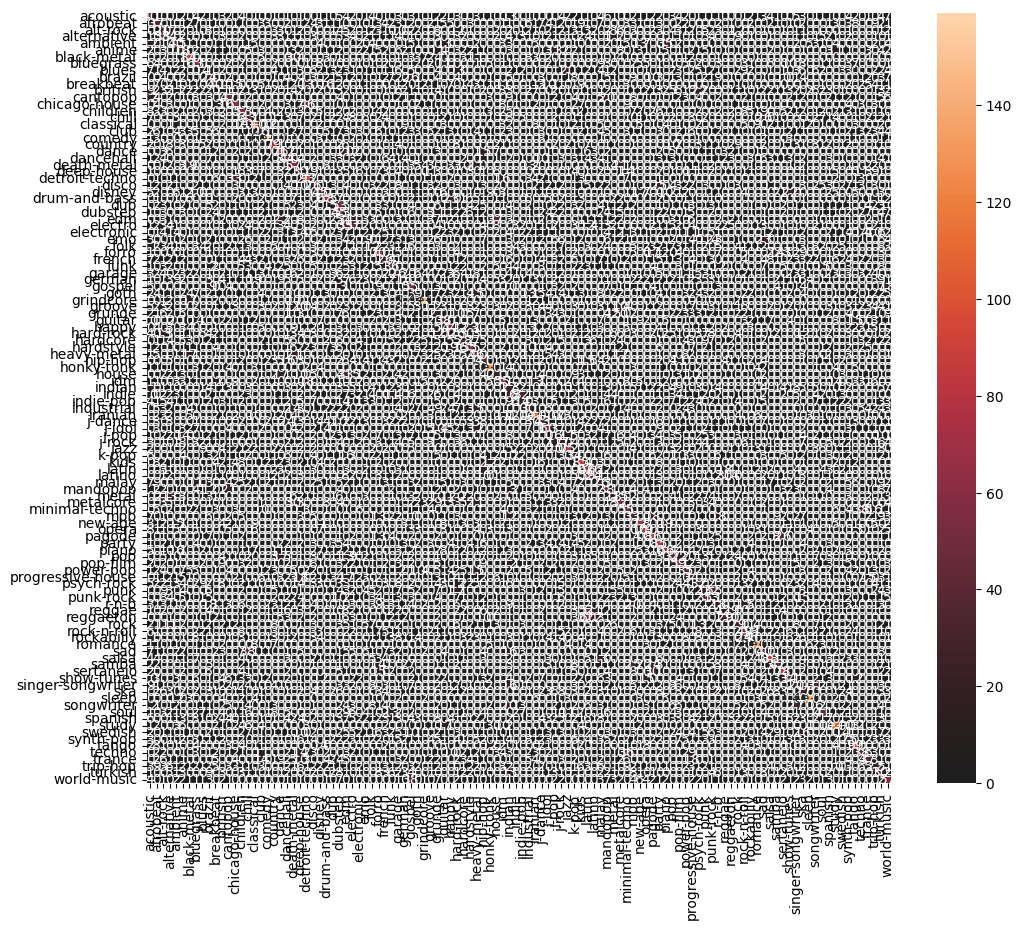

In [21]:
display_metrics(
    grid_search.best_estimator_, df_validation.iloc[:, :-1], df_validation.iloc[:, -1]
)

In [23]:
import pickle

with open("./decision_tree.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

with open("./decision_tree_random_searcher.pkl", "wb") as f:
    pickle.dump(grid_search, f)

In [ ]:
# Tests normality on dataset
def test_normality(data: pd.DataFrame) -> None:
    for column in data.columns:
        if column == "Outcome":
            continue

        # Perform KS test against a normal distribution
        ks_statistic, ks_p_value = sc.stats.kstest(data[column], "norm")

        # Set the significance level
        alpha = 0.05

        # Check for normality based on the p-value
        if ks_p_value > alpha:
            print(
                f"The column {column} is likely normally distributed (fail to reject the null hypothesis) \n KS-stat: {ks_statistic:3f} \n P-Value {ks_p_value:3f}"
            )
        else:
            print(
                f"The column {column} is not normally distributed (reject the null hypothesis) \n KS-stat: {ks_statistic:3f} \n P-Value {ks_p_value:3f}"
            )
